In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
import math
import scipy.stats as ss
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df = df.drop(["Operator", "Registration", "Survivors", "MSN", "Date", "Time",
             "Schedule", "Crew fatalities", "PAX fatalities", "Other fatalities",
             "Circumstances", "Flight no.", "Crash location"], axis=1)

In [4]:
df = df.dropna()

In [5]:
# def label_encoder(column_name, df):
#     lst = list(set(df[column_name]))
#     dct = {lst[i]: i for i in range(len(lst))}
#     df[column_name] = [dct[x] for x in df[column_name]]
#     return dct

# aircrafts = label_encoder("Aircraft", df)
# flight_phases = label_encoder("Flight phase", df)
# flight_types = label_encoder("Flight type", df)
# crash_sites = label_encoder("Crash site", df)
# # crash_locations = label_encoder("Crash location", df)
# countries = label_encoder("Country", df)
# regions = label_encoder("Region", df)
# crash_causes = label_encoder("Crash cause", df)

label_encoder = LabelEncoder()
df = df.apply(lambda col: label_encoder.fit_transform(col) if col.dtype == 'O' else col)

<Axes: >

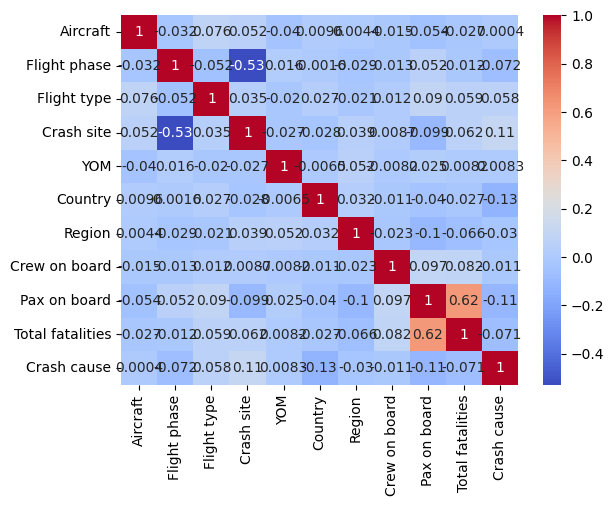

In [6]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", annot_kws={"size": 10})

In [7]:
y = df["Total fatalities"]
X = df.drop("Total fatalities", axis=1)

In [8]:
# Проверка на нормальное распределение выходной величины y

# Правило трёх сигм
data = y
mean_data = np.mean(data)
std_data = np.std(data)

def get_interval(k_sigma, mean_value, std_value):
    return [mean_value - k_sigma * std_value, mean_value + k_sigma * std_value]

def get_percent(k, data):
    mean_data = np.mean(data)
    std_data = np.std(data)

    interval = get_interval(k, mean_data, std_data)

    return sum([1 if x >= interval[0] and x <= interval[1] else 0 for x in data]) / len(data) * 100

percent_68 = get_percent(1, data)
percent_95 = get_percent(2, data)
percent_99 = get_percent(3, data)
print(f"Процент вхождений в интервал 1 сигмы: {percent_68}")
print(f"Процент вхождений в интервал 2 сигм: {percent_95}")
print(f"Процент вхождений в интервал 3 сигм: {percent_99}")

# Критерий Пирсона
# Разделим данные на интервалы
def get_interval_distribution(data):
    k = int(np.round(1 + 3.322 * np.log10(len(data))))
    min_age = math.floor(min(data))
    max_age = math.ceil(max(data))
    h = (max_age - min_age) / k
    
    intervals = [(min_age + i * h, min_age + (i + 1) * h) for i in range(k)]
    distr = {intr:0 for intr in intervals}
    for x in data:
        for intr in intervals:
            if x >= intr[0] and x <= intr[1]:
                distr[intr] += 1
                break
    return (distr, k, h)

def chi_square(data):
    distr, k, h = get_interval_distribution(data)
    sum_xn = 0
    sum_x2n = 0
    # Вычисляем среднее, дисперсию и среднекв. отклонение (х - середина интервала)
    for inter, n in distr.items():
        lower, upper = inter[0], inter[1]
        x = (upper + lower) / 2
        sum_xn += x * n
        sum_x2n += (x ** 2) * n
    mean_value = sum_xn / len(data)
    variance = (sum_x2n / len(data)) - (mean_value ** 2)
    std_value = variance ** 0.5
    # Строим массив теоретических частот
    theor_freqs = []
    freqs = []
    for inter, n in distr.items():
        lower, upper = inter[0], inter[1]
        x = (upper + lower) / 2
        z = (x - mean_value) / std_value
        f_z = math.exp((-(z)**2) / 2) / math.sqrt(2 * math.pi)
        theor_n = ((h * len(data)) / std_value) * f_z
        theor_freqs.append(theor_n)
        freqs.append(n)
    # Хи-квадрат наблюдаемое
    chi2_obs = sum([((freqs[i] - theor_freqs[i]) ** 2) / theor_freqs[i] for i in range(len(distr))])
    print(chi2_obs)
    # Хи-квадрат критическое
    chi2_crit = ss.chi2.ppf(1 - 0.05, k - 1)
    print(chi2_crit)
    return "Отвергаем H0" if chi2_obs > chi2_crit else "Недостаточно оснований отвергнуть H0"
print("Пусть гипотеза H0 - совокупность распределена нормально")
print("На основании проведенного теста с помощью критерия Пирсона: " + chi_square(data))

Процент вхождений в интервал 1 сигмы: 94.64989592098853
Процент вхождений в интервал 2 сигм: 97.14779219628859
Процент вхождений в интервал 3 сигм: 98.2151556756278
Пусть гипотеза H0 - совокупность распределена нормально
1.1197637492286128e+199
23.684791304840576
На основании проведенного теста с помощью критерия Пирсона: Отвергаем H0


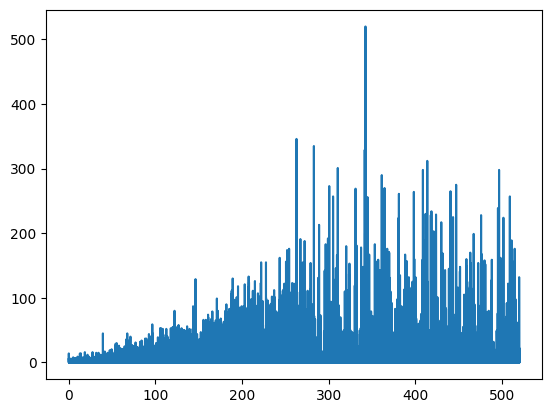

In [9]:
plt.plot(np.linspace(min(data), max(data), len(data)), data)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
def with_intercept(X):
    new_X = X.copy()
    new_X["intercept"] = 1
    return new_X

model = sm.OLS(y, with_intercept(X)).fit()
y_pred = model.predict(with_intercept(X_test))
y_pred = list(map(round, y_pred))

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Total fatalities   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     1502.
Date:                Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:17:51   Log-Likelihood:                -92127.
No. Observations:               22579   AIC:                         1.843e+05
Df Residuals:                   22568   BIC:                         1.844e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Aircraft       4.901e-05      0.000      0.125      0.900      -0.001       0.001
Flight phase      0.4534      0.097      4.684      0.000       0.264       0.643
Flight type      -0.0016      0.012     -0.137      0.891      -0.025       0.022
Crash site        1.2036      0.053     22.924      0.000       1.101       1.307
YOM              -0.0002      0.000     -0.700      0.484      -0.001       0.000
Country       -1.366e-05      0.001     -0.010      0.992      -0.003       0.003
Region           -0.0493      0.050     -0.994      0.320      -0.147       0.048
Crew on board     0.0292      0.007      3.991      0.000       0.015       0.044
Pax on board      0.4352      0.004    118.209      0.000       0.428       0.442
Crash cause      -0.1610      0.055     -2.944      0.003      -0.268      -0.054
intercept         0.0003      0.782      0.000      1.000      -1.532       1.532
==============================================================================
Omnibus:                    14683.697   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2827001.888
Skew:                           2.096   Prob(JB):                         0.00
Kurtosis:                      57.657   Cond. No.                     1.65e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Добавляем переменные
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Добавлено: {best_feature}, p-value = {best_pval:.4f}')
        
        # Удаляем переменные
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Удалено: {worst_feature}, p-value = {worst_pval:.4f}')
        
        if not changed:
            break
    return included

stepwise_selection(X, y)

Добавлено: Pax on board, p-value = 0.0000
Добавлено: Crash site, p-value = 0.0000
Добавлено: Flight phase, p-value = 0.0000
Добавлено: Crew on board, p-value = 0.0001
Добавлено: Crash cause, p-value = 0.0031


['Pax on board', 'Crash site', 'Flight phase', 'Crew on board', 'Crash cause']

In [14]:
print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.4189185484217087
5.8800322061191626
196.51583467525498
